# 수집된 데이터에 대한 통계 분석
* 데이터 
> 2017년 12월 1일부터 2018년 1월 1일까지 32일간 [네이버](http://www.naver.com)와 [다음](http://www.daum.net)의 랭킹뉴스와 뉴스의 댓글을 크롤링함.

In [ ]:
import os
import pandas as pd 
from glob import glob
import sys
import time, re, pickle, itertools
import urllib3, json
sys.path.append('~/Documents/GitHub/Private_Project/personal_project/')
import re
from operator import itemgetter
import html
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import chat_bot as cb
import Database_Handler as dh
from datetime import datetime
import seaborn as sns
import functools
%matplotlib inline

In [ ]:
#site = 'Naver'
site = 'daum'
if site == 'daum':
    binList = []
    collection = 'newsDaum'
elif site.lower() == 'naver':
    binList = []
    collection = 'newsNaver'

mongodb = dh.ToMongoDB(*dh.AWS_MongoDB_Information())
dbname = 'hy_db'
useDb = dh.Use_Database(mongodb, dbname)
useCollection = dh.Use_Collection(useDb, collection)
collection = useCollection.find({'site':site})

In [ ]:
'''
dataDict = dict()
for data in collection:
    dataDict[data['_id']._ObjectId__id.hex()] = idData = dict()
    idData['category'] = data['category']
    idData['date'] = data['date']
    idData['press'] = data['press']
    idData['number_of_comment'] = data['number_of_comment']
    idData['number_of_crawled_comment'] = data['real_number_of_comment']
pickle.dump(dataDict, open('./data/pre_data/for_statistics_'+site+'_from_mongodb.pickled','wb'))
print (len(dataDict))
'''

In [3]:
commentCollection = dh.Use_Collection(useDb, 'comments')

# 네이버 (Naver)

In [4]:
file = './data/pre_data/for_statistics_Naver_from_mongodb.pickled'
dataDict_naver = pickle.load(open(file,'rb'))

In [5]:
df_naver = pd.DataFrame.from_dict(dataDict_naver, orient='index')
df_naver['date'] = pd.to_datetime(df_naver['date']).dt.date
df_naver.reset_index(inplace = True)
df_naver.rename(columns={'index':'id'}, inplace=True)
print (df_naver.shape)
df_naver.head()

(7681, 6)


,id,category,date,press,number_of_comment,number_of_crawled_comment
0,5a29c445588c132954d1973a,정치,2017-12-07,연합뉴스,1713,1474
1,5a29c445588c132954d1973b,정치,2017-12-07,한국일보,2551,2121
2,5a29c445588c132954d1973c,정치,2017-12-07,뉴시스,610,540
3,5a29c445588c132954d1973d,정치,2017-12-07,연합뉴스,145,134
4,5a29c445588c132954d1973e,정치,2017-12-07,동아일보,1074,937


## 뉴스기사

### 일별 뉴스기사수

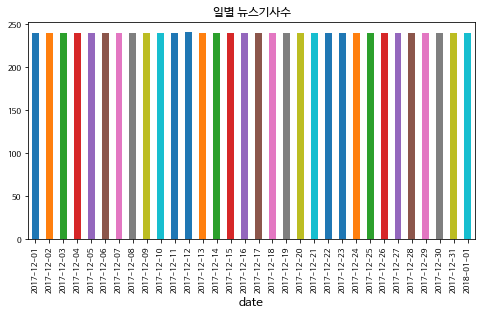

In [67]:
f1 = plt.figure(figsize=(8,4))
plt.title('일별 뉴스기사수', color='black')
df_naver.groupby('date')['id'].count().plot(kind = 'bar',rot=90,ax=f1.gca())
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlabel('date',fontsize=12)
plt.show()

* 2017년 12월 12일은 241개, 나머지는 240개
> * 총 7681개의 뉴스기사

### 일별 & 카테고리별 뉴스기사수

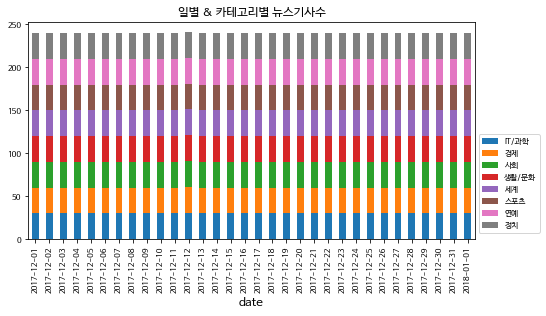

In [68]:
f1 = plt.figure(figsize=(8,4))
plt.title('일별 & 카테고리별 뉴스기사수', color='black')
df_naver.groupby(['date','category'])['id'].count().unstack().plot(kind='bar',stacked=True,ax=f1.gca())
plt.legend(loc='best', bbox_to_anchor=(1.0, 0.5),fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlabel('date',fontsize=12)
plt.show()

* 8개의 카테고리별로 30개씩 하루에 240개, 2017년 12월 12일만 경제 카테고리에서 31개임

### 일별 & 언론별 뉴스기사수

In [130]:
print ('언론사수 : {}, 날짜수 : {}'.format(len(df_naver['press'].unique()), len(df_naver['date'].unique())))

언론사수 : 93, 날짜수 : 32


* 뉴스기사가 하나라도 있는 언론의 수가 93개
> * 너무 많다!!!


In [143]:
date_press_naver = df_naver.groupby(['date','press'])['id'].count().unstack()

No handles with labels found to put in legend.


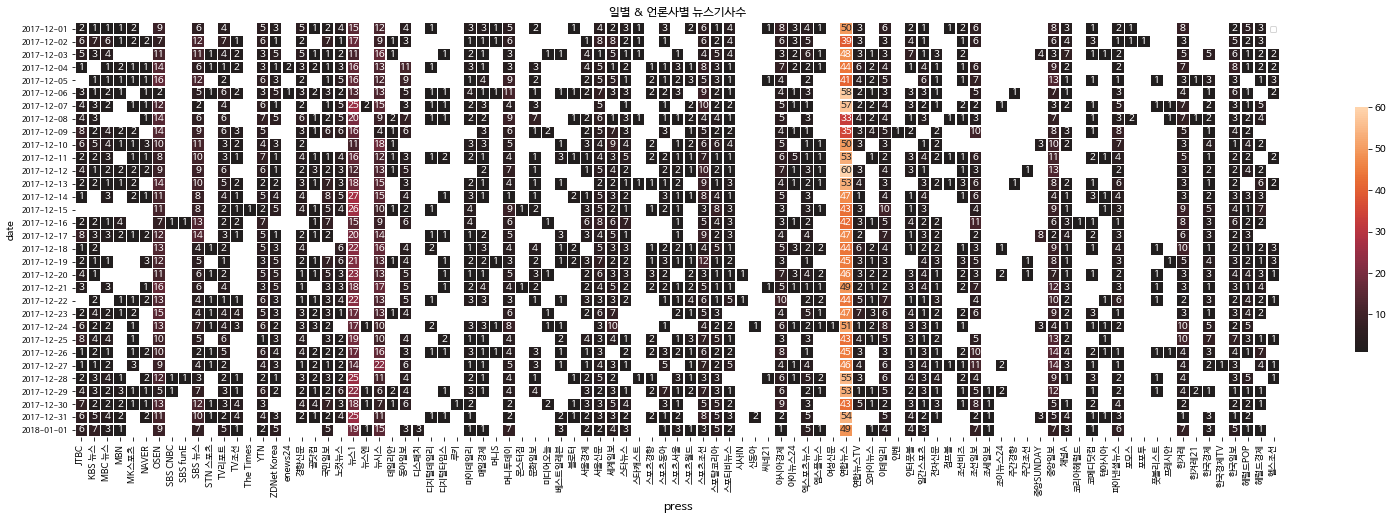

In [317]:
f1 = plt.figure(figsize=(27,9))
plt.title('일별 & 언론사별 뉴스기사수', color='black')
sns.heatmap(date_press_naver, center=0, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=f1.gca())
plt.legend(loc='best',fontsize=8)
plt.xticks(fontsize=9)
plt.yticks(fontsize=8)
plt.xlabel('press',fontsize=12)
plt.show()

* 알아보기 힘들다
* 언론사의 특정 카테고리 관련 계열 언론, 주간지 또는 월간지의 경우, 특정일에는 없는 경우도 존재함
> * SBS CNBC, SBS funE, The Times, enews24, 디스패치, 머니S, 몬스터짐, 스타캐스트, 시사IN, 신동아, 씨네21, 여성신문, 인벤, 점프볼, 조이뉴스24, 주간경향, 주간조선, 중앙SUNDAY, 코리아헤럴드, 포브스, 포포투, 풋볼리스트, 프레시안, 한겨레21, 한국경제TV 등은 대체로 0이고, 전체적으로 전체중에서 10건 미만의 기사가 등록되어진 것으로 보임

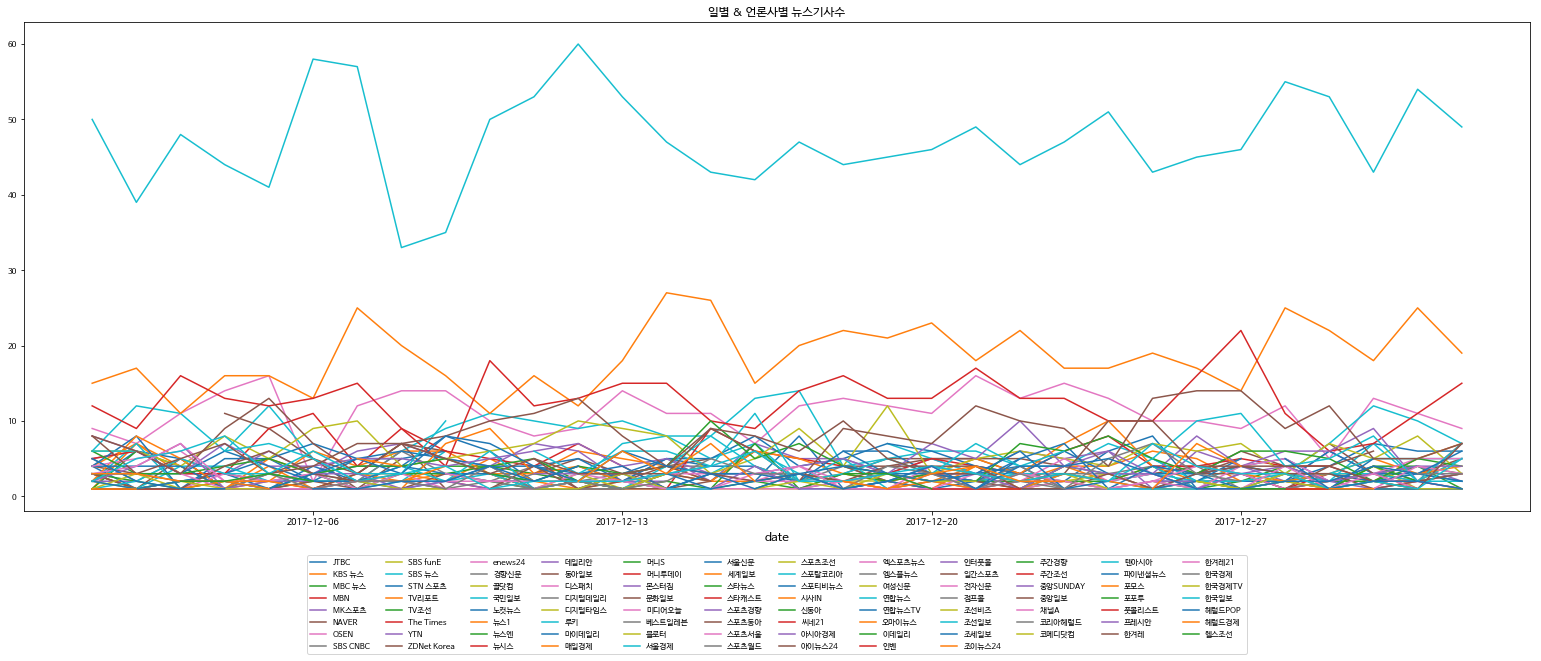

In [253]:
f1 = plt.figure(figsize=(27,9))
plt.title('일별 & 언론사별 뉴스기사수', color='black')
date_press_naver.plot(kind='line',ax=f1.gca())
plt.legend(loc='lower center',fontsize=8, bbox_to_anchor=(0.5,-0.3),ncol = 12)
plt.xticks(fontsize=9)
plt.yticks(fontsize=8)
plt.xlabel('date',fontsize=12)
plt.show()

* 알아보기 힘듦
* 연합뉴스는 특히 많음

#### 뉴스량 상위 10, 상위 30 개 언론사를 대상으로 그래프를 그려보자

In [264]:
total_5_press = date_press_naver.sum(axis = 0).sort_values(ascending=False)[:5].index
total_10_press = date_press_naver.sum(axis = 0).sort_values(ascending=False)[:10].index
total_30_press = date_press_naver.sum(axis = 0).sort_values(ascending=False)[:30].index

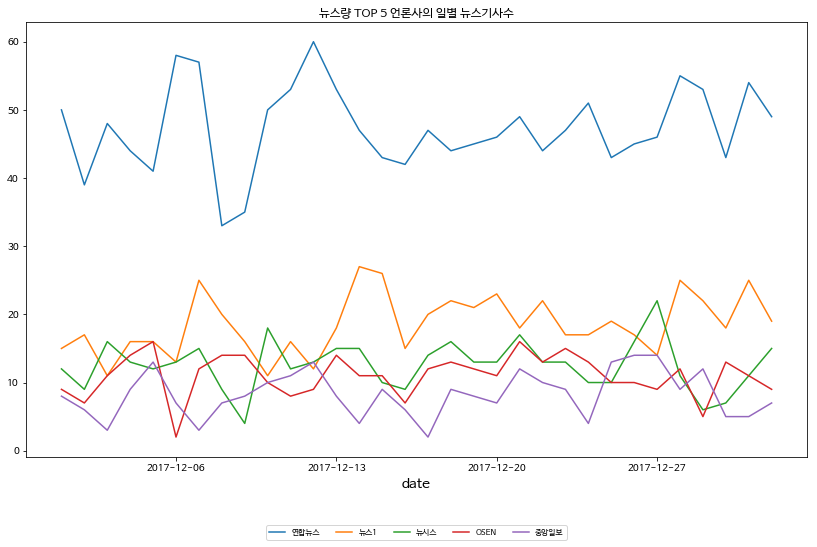

In [272]:
f1 = plt.figure(figsize=(14,8))
plt.title('뉴스량 TOP 5 언론사의 일별 뉴스기사수', color='black')
date_press_naver.loc[:,total_5_press].plot(kind='line',ax=f1.gca())
plt.legend(loc='lower center',fontsize=8, bbox_to_anchor=(0.5,-0.2),ncol = 10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel('date',fontsize=14)
plt.show()

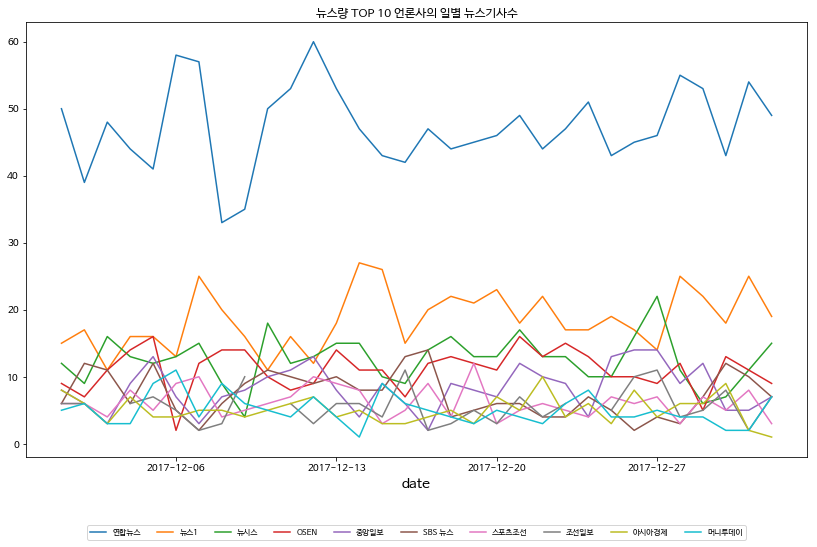

In [273]:
f1 = plt.figure(figsize=(14,8))
plt.title('뉴스량 TOP 10 언론사의 일별 뉴스기사수', color='black')
date_press_naver.loc[:,total_10_press].plot(kind='line',ax=f1.gca())
plt.legend(loc='lower center',fontsize=8, bbox_to_anchor=(0.5,-0.2),ncol = 10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel('date',fontsize=14)
plt.show()

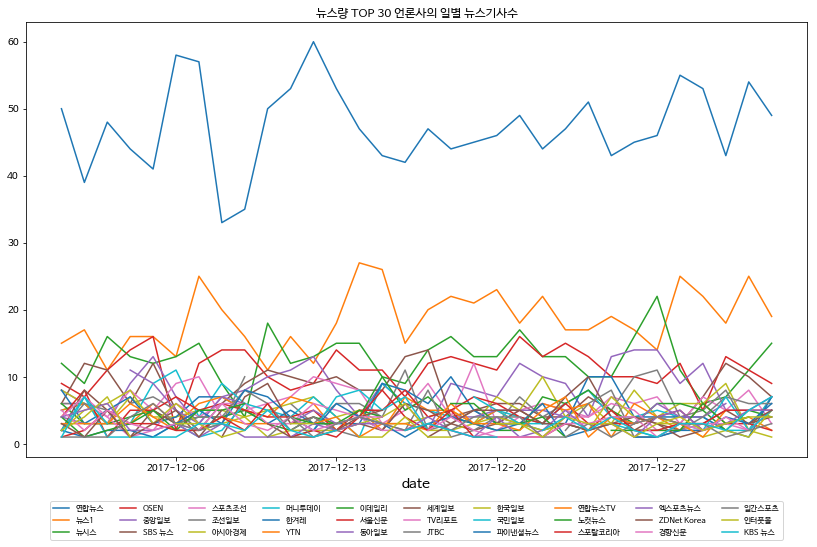

In [274]:
f1 = plt.figure(figsize=(14,8))
plt.title('뉴스량 TOP 30 언론사의 일별 뉴스기사수', color='black')
date_press_naver.loc[:,total_30_press].plot(kind='line',ax=f1.gca())
plt.legend(loc='lower center',fontsize=8, bbox_to_anchor=(0.5,-0.2),ncol = 10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel('date',fontsize=14)
plt.show()

* TOP5는 연합뉴스, 뉴스1, 뉴시스, OSEN, 중앙일보
> 연합뉴스, 뉴스1, 뉴시스는 통신사

* 통신사 : 독자적인 취재조직을 가지고 수집한 뉴스를 신문사와 방송국에 제공하는 기관
> 대한민국 뉴스 통신사로는 연합뉴스 외에 뉴시스, 뉴스1, 아시아뉴스통신, 포커스뉴스, NSP통신 등  

* [연합뉴스](http://www.yonhapnews.co.kr/)
> 연합뉴스(聯合뉴스)는 방송과 신문, 정부, 포털 사이트, 기타 예약 구독자에게 기사를 공급하는 뉴스통신사  
> 국내외 취재망을 구축해 제작한 기사를 대한민국의 각종 신문사와 방송사와 행정부 각 부처와 주요 기관, 주요 기업체, 인터넷 매체와 국외 계약 매체에도 공급  
> 정치, 경제, 사회, 문화. 연예, 스포츠, 레저, 과학, 정보, 지방, 외신에 관계된 국내외 뉴스 하루 3천여 건을 제공  
> 2003년 제정된 「뉴스통신진흥에관한법률」에 의거해 국가 기간 통신사로 지정됐고 국내에 전문 취재 기자 580여 명과 워싱턴, 파리, 모스크바, 도쿄(東京), 베이징(北京)을 위시해 전 세계 30여개 주요 지역에 특파원과 통신원 60여 명을 파견


### 카테고리별 & 언론사별 뉴스기사

In [305]:
category_press_naver = df_naver.groupby(['category','press'])['id'].count()

In [360]:
sortedcpn = category_press_naver.unstack().loc[:,date_press_naver.sum(axis = 0).sort_values(ascending=False).index]

No handles with labels found to put in legend.


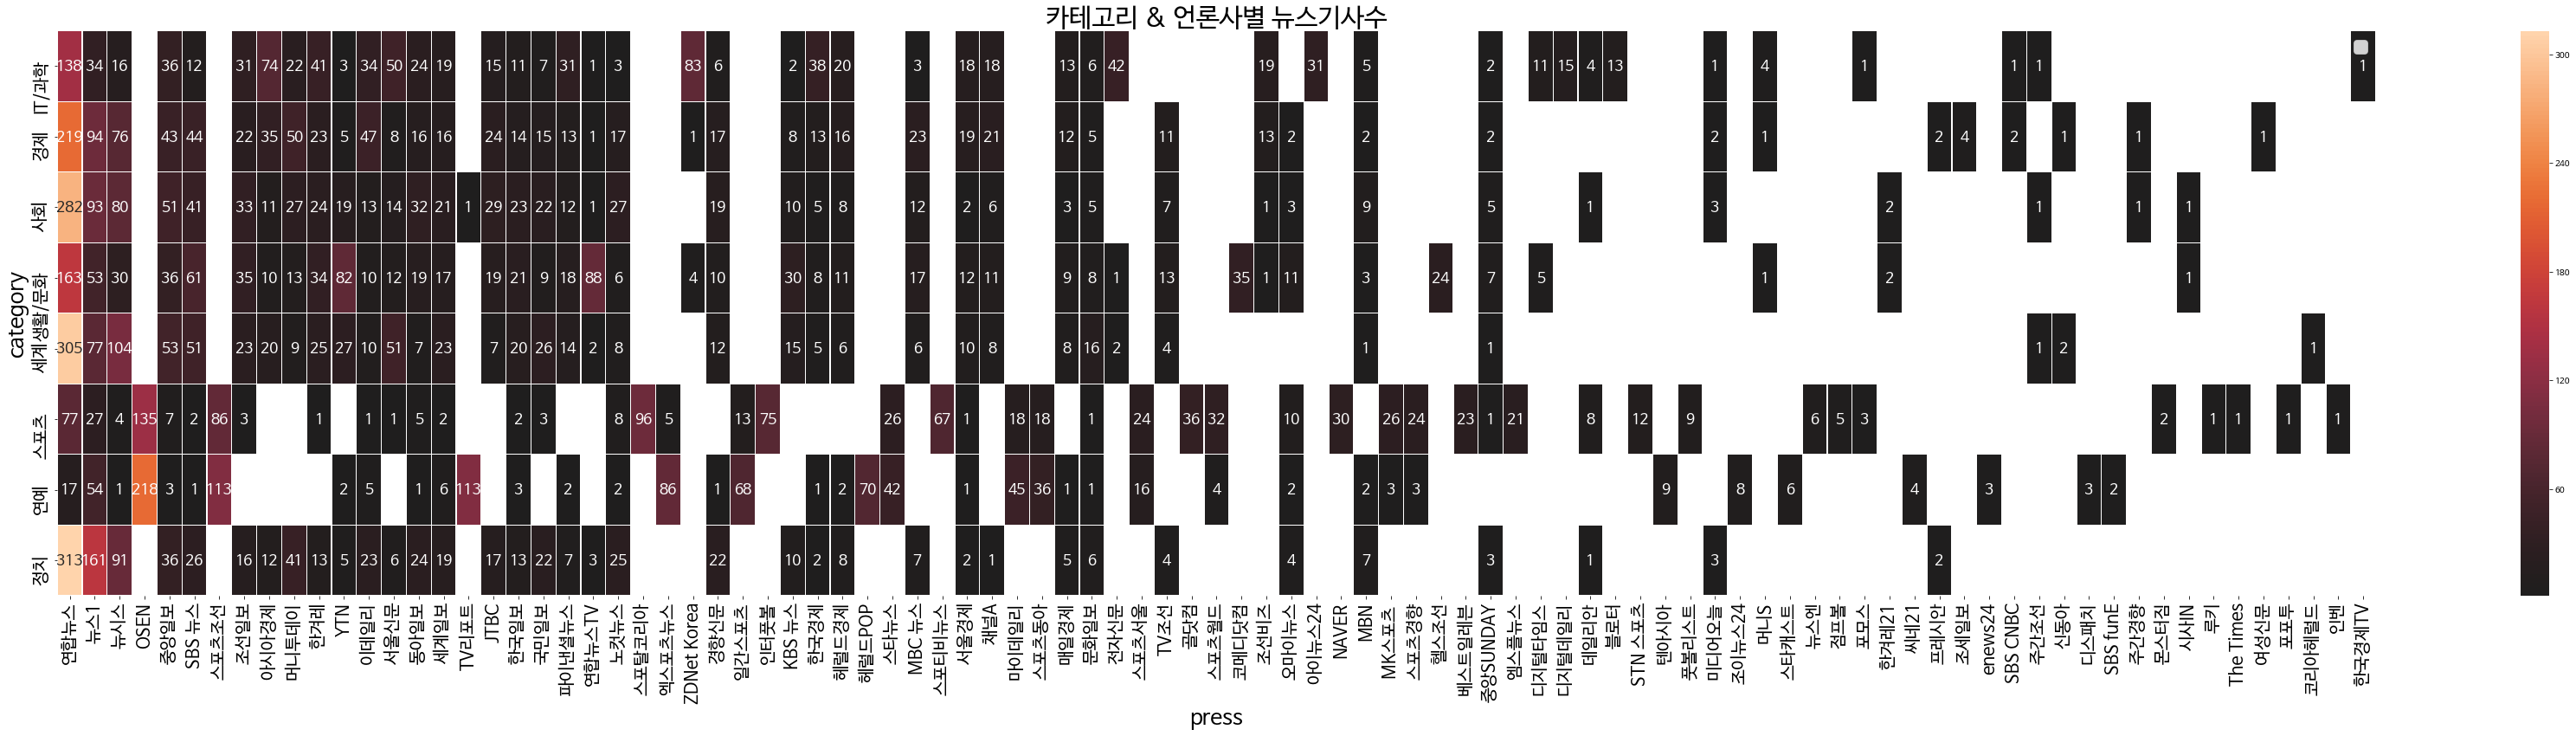

In [374]:
f1 = plt.figure(figsize=(60,12))
plt.title('카테고리 & 언론사별 뉴스기사수', color='black',fontsize=30)
sns.heatmap(sortedcpn, center=0, annot=True, fmt='.0f',annot_kws={"size": 17.5},
            linewidths=.25, cbar_kws={"shrink": 1}, ax=f1.gca())
plt.legend(loc='best',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('press',fontsize=25)
plt.ylabel('category',fontsize=25)
plt.show()

In [405]:
sePress = sortedcpn.loc[:,sortedcpn.loc[['스포츠','연예'],:].sum()!=0]

In [408]:
fis= sePress.loc[:,sePress.loc[sePress.index.difference(['스포츠','연예']),:].sum(axis = 0) <=1]
fis.columns

Index(['OSEN', '스포츠조선', 'TV리포트', '스포탈코리아', '엑스포츠뉴스', '일간스포츠', '인터풋볼', '헤럴드POP',
       '스타뉴스', '스포티비뉴스', '마이데일리', '스포츠동아', '스포츠서울', '골닷컴', '스포츠월드', 'NAVER',
       'MK스포츠 ', '스포츠경향', '베스트일레븐', '엠스플뉴스', 'STN 스포츠', '텐아시아', '풋볼리스트',
       '조이뉴스24', '스타캐스트', '뉴스엔', '점프볼', '포모스', '씨네21', 'enews24', '디스패치',
       'SBS funE', '몬스터짐', '루키', 'The Times', '포포투', '인벤'],
      dtype='object', name='press')

* 연예, 스포츠 특화 매체로 판단되는 언론매체
> OSEN, 스포츠조선, TV리포트, 스포탈코리아, 엑스포츠뉴스, 일간스포츠, 인터풋볼, 헤럴드POP, 스타뉴스, 스포티비뉴스, 마이데일리, 스포츠동아, 스포츠서울, 골닷컴, 스포츠월드, NAVER, MK스포츠, 스포츠경향, 베스트일레븐, 엠스플뉴스, STN 스포츠, 텐아시아, 풋볼리스트, 조이뉴스24, 스타캐스트, 뉴스엔, 점프볼, 포모스, 씨네21, enews24, 디스패치, SBS funE, 몬스터짐, 루키, The Times, 포포투, 인벤 등의 매체는 스포츠나 연예쪽에 특화된 매체인 것으로 판단됨. 
> NAVER의 경우, NAVER 자체의 전문가칼럼 또는 NAVER에서만 제공되는 뉴스정보인 것으로 판단됨

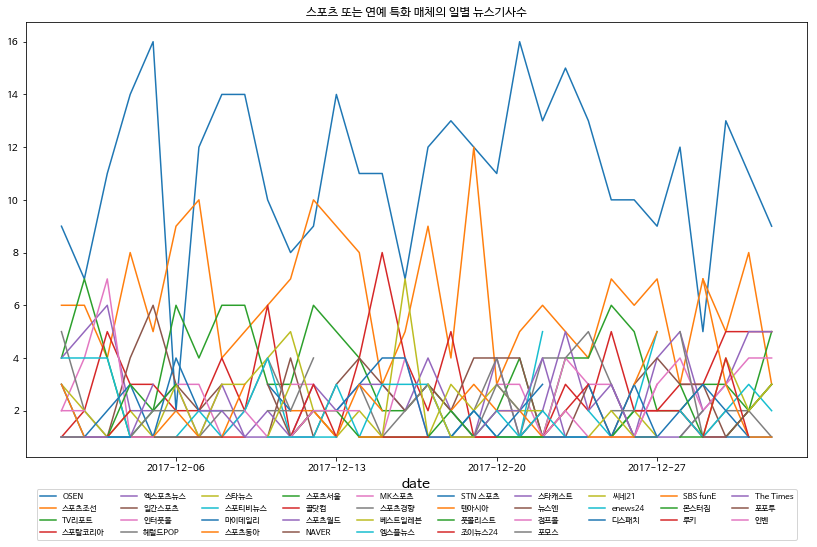

In [411]:
f1 = plt.figure(figsize=(14,8))
plt.title('스포츠 또는 연예 특화 매체의 일별 뉴스기사수', color='black')
date_press_naver.loc[:,fis.columns].plot(kind='line',ax=f1.gca())
plt.legend(loc='lower center',fontsize=8, bbox_to_anchor=(0.5,-0.2),ncol = 10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel('date',fontsize=14)
plt.show()

## 댓글 분석

### 요일별 정리

In [ ]:
group_by_date = df.groupby('date')['number_of_comment', 'number_of_crawled_comment']

In [ ]:
f = plt.figure(figsize=(12,4))
plt.title('요일별 평균 댓글수와 평균 크롤링된 댓글수', color='black')
group_by_date.mean().plot(kind='line', ax=f.gca())
plt.legend(loc='best', bbox_to_anchor=(1.0, 0.5))
plt.show()

* 등록된 댓글수와 실제 크롤링된 댓글수가 차이를 보이는 것은 작성자가 삭제하였거나, 스팸신고, 타 사용자의 신고로 삭제된 댓글이 존재하기 때문임

### 요일별 & 카테고리별 정리

In [ ]:
group_by_date_category = df.groupby(['date', 'category'])['number_of_comment', 'number_of_crawled_comment']

In [ ]:
f = plt.figure(figsize=(16,4))
plt.title('요일별 카테고리별 평균 댓글수', color='black')
group_by_date_category.mean()['number_of_comment'].unstack().plot(ax=f.gca())
plt.legend(loc='best', bbox_to_anchor=(1.0, 0.5))
plt.show()

In [ ]:
f = plt.figure(figsize=(16,4))
plt.title('요일별 카테고리별 평균 크롤링된 댓글수', color='black')
group_by_date_category.mean()['number_of_crawled_comment'].unstack().plot(kind='line', ax=f.gca())
plt.legend(loc='best', bbox_to_anchor=(1.0, 0.5))
plt.show()

### 카테고리별 정리

In [ ]:
group_by_category = df.groupby('category')['number_of_comment', 'number_of_crawled_comment']

In [ ]:
f = plt.figure(figsize=(6,4))
plt.title('카테고리별 평균 댓글수와 평균 크롤링된 댓글수', color='black')
group_by_category.mean().plot.barh( ax=f.gca())
plt.legend(loc='best', bbox_to_anchor=(1.0, 0.5))
plt.show()

In [ ]:
fDf = df[['category','number_of_comment', 'number_of_crawled_comment']]

In [ ]:
f = plt.figure(figsize=(8,10))
plt.title('카테고리별 평균 댓글수와 평균 크롤링된 댓글수', color='black')
dd = pd.melt(fDf, id_vars = ['category'], value_vars=['number_of_comment', 'number_of_crawled_comment'],var_name='x')
sns.boxplot(x = 'category', y = 'value', data =dd, hue = 'x', ax=f.gca())
plt.show()

# 다음 (Daum)

In [ ]:
file2 = './data/pre_data/for_statistics_daum_from_mongodb.pickled'
dataDict2 = pickle.load(open(file2,'rb'))

In [ ]:
df2 = pd.DataFrame.from_dict(dataDict2, orient='index')
df2['date'] = pd.to_datetime(df2['date']).dt.date
df2.reset_index(inplace = True)
df2.rename(columns={'index':'id'}, inplace=True)
print (df2.shape)
df2.head()

In [ ]:
f = plt.figure(figsize=(5,8))
df2.groupby('date')['id'].count().plot(kind = 'barh')

## 댓글 분석

### 요일별 정리

In [ ]:
group2_by_date = df2.groupby('date')['number_of_comment', 'number_of_crawled_comment']

In [ ]:
f = plt.figure(figsize=(16,4))
plt.title('요일별 평균 댓글수와 평균 크롤링된 댓글수', color='black')
group2_by_date.mean().plot(ax=f.gca())
plt.legend(loc='best', bbox_to_anchor=(1.0, 0.5))
plt.show()

* 등록된 댓글수와 실제 크롤링된 댓글수가 차이를 보이는 것은 작성자가 삭제하였거나, 스팸신고, 타 사용자의 신고로 삭제된 댓글이 존재하기 때문임

### 요일별 & 카테고리별 정리

In [ ]:
group2_by_date_category = df2.groupby(['date', 'category'])['number_of_comment', 'number_of_crawled_comment']

In [ ]:
f = plt.figure(figsize=(16,4))
plt.title('요일별 카테고리별 평균 댓글수', color='black')
group2_by_date_category.mean().unstack().plot(ax=f.gca(),by='category')
plt.legend(loc='best', bbox_to_anchor=(1.0, 0.5))
plt.show()

### 카테고리별 정리

In [ ]:
group2_by_category = df2.groupby('category')['number_of_comment', 'number_of_crawled_comment']

In [ ]:
f = plt.figure(figsize=(6,4))
plt.title('카테고리별 평균 댓글수와 평균 크롤링된 댓글수', color='black')
group2_by_category.mean().plot.barh( ax=f.gca())
plt.legend(loc='best', bbox_to_anchor=(1.0, 0.5))
plt.show()

In [ ]:
fDf2 = df2[['category','number_of_comment', 'number_of_crawled_comment']]

In [ ]:
f = plt.figure(figsize=(8,10))
plt.title('카테고리별 평균 댓글수와 평균 크롤링된 댓글수', color='black')
dd2 = pd.melt(fDf2, id_vars = ['category'], value_vars=['number_of_comment', 'number_of_crawled_comment'],var_name='x')
sns.boxplot(x = 'category', y = 'value', data =dd2, hue = 'x', ax=f.gca())
plt.show()